In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.custom_baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 27:59 - loss: 2.3980

  9/146 [>.............................] - ETA: 0s - loss: 2.3939   

 17/146 [==>...........................] - ETA: 0s - loss: 2.3849

 26/146 [====>.........................] - ETA: 0s - loss: 2.3673

 35/146 [======>.......................] - ETA: 0s - loss: 2.3478

 44/146 [========>.....................] - ETA: 0s - loss: 2.3291

 53/146 [=========>....................] - ETA: 0s - loss: 2.3112



 62/146 [===========>..................] - ETA: 0s - loss: 2.2942



 71/146 [=============>................] - ETA: 0s - loss: 2.2780

 80/146 [===============>..............] - ETA: 0s - loss: 2.2624

 90/146 [=================>............] - ETA: 0s - loss: 2.2460



100/146 [===================>..........] - ETA: 0s - loss: 2.2306

109/146 [=====================>........] - ETA: 0s - loss: 2.2176

118/146 [=======================>......] - ETA: 0s - loss: 2.2055

128/146 [=========================>....] - ETA: 0s - loss: 2.1928

137/146 [===========================>..] - ETA: 0s - loss: 2.1819

146/146 [==============================] - ETA: 0s - loss: 2.1717

146/146 [==============================] - 13s 9ms/step - loss: 2.1706 - val_loss: 1.8241


Epoch 2/100


  1/146 [..............................] - ETA: 0s - loss: 1.7670

 10/146 [=>............................] - ETA: 0s - loss: 1.7961

 19/146 [==>...........................] - ETA: 0s - loss: 1.7969

 28/146 [====>.........................] - ETA: 0s - loss: 1.7968

 37/146 [======>.......................] - ETA: 0s - loss: 1.7959

 46/146 [========>.....................] - ETA: 0s - loss: 1.7950

 55/146 [==========>...................] - ETA: 0s - loss: 1.7938



 64/146 [============>.................] - ETA: 0s - loss: 1.7924



 73/146 [==============>...............] - ETA: 0s - loss: 1.7911



 82/146 [===============>..............] - ETA: 0s - loss: 1.7897



 91/146 [=================>............] - ETA: 0s - loss: 1.7881



100/146 [===================>..........] - ETA: 0s - loss: 1.7866



109/146 [=====================>........] - ETA: 0s - loss: 1.7850

118/146 [=======================>......] - ETA: 0s - loss: 1.7835

128/146 [=========================>....] - ETA: 0s - loss: 1.7820

137/146 [===========================>..] - ETA: 0s - loss: 1.7806

146/146 [==============================] - 1s 6ms/step - loss: 1.7791 - val_loss: 1.7446


Epoch 3/100
  1/146 [..............................] - ETA: 1s - loss: 1.7147

 10/146 [=>............................] - ETA: 0s - loss: 1.6967

 19/146 [==>...........................] - ETA: 0s - loss: 1.6945

 28/146 [====>.........................] - ETA: 0s - loss: 1.6942

 37/146 [======>.......................] - ETA: 0s - loss: 1.6938

 46/146 [========>.....................] - ETA: 0s - loss: 1.6932

 55/146 [==========>...................] - ETA: 0s - loss: 1.6928

 64/146 [============>.................] - ETA: 0s - loss: 1.6922

 73/146 [==============>...............] - ETA: 0s - loss: 1.6915

 82/146 [===============>..............] - ETA: 0s - loss: 1.6906

 91/146 [=================>............] - ETA: 0s - loss: 1.6897

 99/146 [===================>..........] - ETA: 0s - loss: 1.6888

108/146 [=====================>........] - ETA: 0s - loss: 1.6879

117/146 [=======================>......] - ETA: 0s - loss: 1.6870

126/146 [========================>.....] - ETA: 0s - loss: 1.6860

135/146 [==========================>...] - ETA: 0s - loss: 1.6851

144/146 [============================>.] - ETA: 0s - loss: 1.6842

146/146 [==============================] - 1s 6ms/step - loss: 1.6840 - val_loss: 1.7552


Epoch 4/100
  1/146 [..............................] - ETA: 0s - loss: 1.7148

 10/146 [=>............................] - ETA: 0s - loss: 1.6936

 20/146 [===>..........................] - ETA: 0s - loss: 1.6818

 29/146 [====>.........................] - ETA: 0s - loss: 1.6760

 38/146 [======>.......................] - ETA: 0s - loss: 1.6713

 47/146 [========>.....................] - ETA: 0s - loss: 1.6671

 56/146 [==========>...................] - ETA: 0s - loss: 1.6636

 65/146 [============>.................] - ETA: 0s - loss: 1.6603

 74/146 [==============>...............] - ETA: 0s - loss: 1.6573

 83/146 [================>.............] - ETA: 0s - loss: 1.6544

 93/146 [==================>...........] - ETA: 0s - loss: 1.6514

102/146 [===================>..........] - ETA: 0s - loss: 1.6491

110/146 [=====================>........] - ETA: 0s - loss: 1.6472



119/146 [=======================>......] - ETA: 0s - loss: 1.6453

127/146 [=========================>....] - ETA: 0s - loss: 1.6437

135/146 [==========================>...] - ETA: 0s - loss: 1.6423

144/146 [============================>.] - ETA: 0s - loss: 1.6408

146/146 [==============================] - 1s 6ms/step - loss: 1.6404 - val_loss: 1.6640


Epoch 5/100
  1/146 [..............................] - ETA: 1s - loss: 1.5931

 10/146 [=>............................] - ETA: 0s - loss: 1.5951

 19/146 [==>...........................] - ETA: 0s - loss: 1.5979

 28/146 [====>.........................] - ETA: 0s - loss: 1.5954



 35/146 [======>.......................] - ETA: 0s - loss: 1.5940



 43/146 [=======>......................] - ETA: 0s - loss: 1.5920

 52/146 [=========>....................] - ETA: 0s - loss: 1.5900

 61/146 [===========>..................] - ETA: 0s - loss: 1.5881

 70/146 [=============>................] - ETA: 0s - loss: 1.5866

 79/146 [===============>..............] - ETA: 0s - loss: 1.5852

 88/146 [=================>............] - ETA: 0s - loss: 1.5839

 97/146 [==================>...........] - ETA: 0s - loss: 1.5828

105/146 [====================>.........] - ETA: 0s - loss: 1.5818

115/146 [======================>.......]

 - ETA: 0s - loss: 1.5808

124/146 [========================>.....] - ETA: 0s - loss: 1.5801

133/146 [==========================>...] - ETA: 0s - loss: 1.5794

142/146 [============================>.] - ETA: 0s - loss: 1.5788

146/146 [==============================] - 1s 6ms/step - loss: 1.5785 - val_loss: 1.6321


Epoch 6/100
  1/146 [..............................] - ETA: 1s - loss: 1.5378

 10/146 [=>............................] - ETA: 0s - loss: 1.5563

 19/146 [==>...........................] - ETA: 0s - loss: 1.5554

 28/146 [====>.........................] - ETA: 0s - loss: 1.5531

 37/146 [======>.......................] - ETA: 0s - loss: 1.5509

 46/146 [========>.....................] - ETA: 0s - loss: 1.5490

 55/146 [==========>...................] - ETA: 0s - loss: 1.5474

 64/146 [============>.................] - ETA: 0s - loss: 1.5460

 73/146 [==============>...............] - ETA: 0s - loss: 1.5447

 82/146 [===============>..............] - ETA: 0s - loss: 1.5435

 91/146 [=================>............] - ETA: 0s - loss: 1.5424

100/146 [===================>..........] - ETA: 0s - loss: 1.5415

109/146 [=====================>........] - ETA: 0s - loss: 1.5406

118/146 [=======================>......] - ETA: 0s - loss: 1.5398

127/146 [=========================>....] - ETA: 0s - loss: 1.5391

136/146 [==========================>...] - ETA: 0s - loss: 1.5384

145/146 [============================>.] - ETA: 0s - loss: 1.5379

146/146 [==============================] - 1s 6ms/step - loss: 1.5377 - val_loss: 1.6257


Epoch 7/100
  1/146 [..............................] - ETA: 1s - loss: 1.4750

 10/146 [=>............................] - ETA: 0s - loss: 1.5279

 19/146 [==>...........................] - ETA: 0s - loss: 1.5240

 28/146 [====>.........................] - ETA: 0s - loss: 1.5203

 37/146 [======>.......................] - ETA: 0s - loss: 1.5180

 46/146 [========>.....................] - ETA: 0s - loss: 1.5157



 55/146 [==========>...................] - ETA: 0s - loss: 1.5134

 64/146 [============>.................] - ETA: 0s - loss: 1.5116

 73/146 [==============>...............] - ETA: 0s - loss: 1.5101

 82/146 [===============>..............] - ETA: 0s - loss: 1.5090

 91/146 [=================>............] - ETA: 0s - loss: 1.5080

100/146 [===================>..........] - ETA: 0s - loss: 1.5069

109/146 [=====================>........] - ETA: 0s - loss: 1.5060

118/146 [=======================>......] - ETA: 0s - loss: 1.5051

127/146 [=========================>....] - ETA: 0s - loss: 1.5044

136/146 [==========================>...] - ETA: 0s - loss: 1.5036

145/146 [============================>.] - ETA: 0s - loss: 1.5030

146/146 [==============================] - 1s 6ms/step - loss: 1.5028 - val_loss: 1.6034


Epoch 8/100
  1/146 [..............................] - ETA: 1s - loss: 1.4398

  9/146 [>.............................] - ETA: 0s - loss: 1.4497

 18/146 [==>...........................] - ETA: 0s - loss: 1.4527

 27/146 [====>.........................] - ETA: 0s - loss: 1.4543

 36/146 [======>.......................] - ETA: 0s - loss: 1.4549

 44/146 [========>.....................] - ETA: 0s - loss: 1.4546

 53/146 [=========>....................] - ETA: 0s - loss: 1.4545

 62/146 [===========>..................] - ETA: 0s - loss: 1.4544

 71/146 [=============>................] - ETA: 0s - loss: 1.4540

 80/146 [===============>..............] - ETA: 0s - loss: 1.4536

 89/146 [=================>............] - ETA: 0s - loss: 1.4531

 97/146 [==================>...........] - ETA: 0s - loss: 1.4526



106/146 [====================>.........] - ETA: 0s - loss: 1.4520

114/146 [======================>.......] - ETA: 0s - loss: 1.4514

123/146 [========================>.....] - ETA: 0s - loss: 1.4509

132/146 [==========================>...] - ETA: 0s - loss: 1.4504

141/146 [===========================>..] - ETA: 0s - loss: 1.4500

146/146 [==============================] - 1s 6ms/step - loss: 1.4497 - val_loss: 1.6195


Epoch 9/100
  1/146 [..............................] - ETA: 0s - loss: 1.4055

 10/146 [=>............................] - ETA: 0s - loss: 1.4440

 19/146 [==>...........................] - ETA: 0s - loss: 1.4418

 28/146 [====>.........................] - ETA: 0s - loss: 1.4365

 37/146 [======>.......................] - ETA: 0s - loss: 1.4314

 46/146 [========>.....................] - ETA: 0s - loss: 1.4273

 55/146 [==========>...................] - ETA: 0s - loss: 1.4238

 64/146 [============>.................] - ETA: 0s - loss: 1.4209

 73/146 [==============>...............] - ETA: 0s - loss: 1.4185

 82/146 [===============>..............] - ETA: 0s - loss: 1.4165

 91/146 [=================>............] - ETA: 0s - loss: 1.4149

100/146 [===================>..........] - ETA: 0s - loss: 1.4134

109/146 [=====================>........] - ETA: 0s - loss: 1.4122

118/146 [=======================>......] - ETA: 0s - loss: 1.4112

127/146 [=========================>....] - ETA: 0s - loss: 1.4103



136/146 [==========================>...] - ETA: 0s - loss: 1.4095

145/146 [============================>.] - ETA: 0s - loss: 1.4089

146/146 [==============================] - 1s 6ms/step - loss: 1.4088 - val_loss: 1.5621


Epoch 10/100
  1/146 [..............................] - ETA: 0s - loss: 1.3570

 10/146 [=>............................] - ETA: 0s - loss: 1.3649

 19/146 [==>...........................] - ETA: 0s - loss: 1.3712

 28/146 [====>.........................] - ETA: 0s - loss: 1.3711

 37/146 [======>.......................] - ETA: 0s - loss: 1.3708

 46/146 [========>.....................] - ETA: 0s - loss: 1.3707

 55/146 [==========>...................] - ETA: 0s - loss: 1.3700

 64/146 [============>.................] - ETA: 0s - loss: 1.3696

 73/146 [==============>...............] - ETA: 0s - loss: 1.3692

 82/146 [===============>..............] - ETA: 0s - loss: 1.3690

 91/146 [=================>............] - ETA: 0s - loss: 1.3688

100/146 [===================>..........] - ETA: 0s - loss: 1.3686

109/146 [=====================>........] - ETA: 0s - loss: 1.3684

118/146 [=======================>......] - ETA: 0s - loss: 1.3682

127/146 [=========================>....] - ETA: 0s - loss: 1.3680

136/146 [==========================>...] - ETA: 0s - loss: 1.3679

145/146 [============================>.] - ETA: 0s - loss: 1.3678

146/146 [==============================] - 1s 6ms/step - loss: 1.3678 - val_loss: 1.5451


Epoch 11/100
  1/146 [..............................] - ETA: 1s - loss: 1.3187

 10/146 [=>............................] - ETA: 0s - loss: 1.3372

 19/146 [==>...........................] - ETA: 0s - loss: 1.3457

 28/146 [====>.........................] - ETA: 0s - loss: 1.3485

 37/146 [======>.......................] - ETA: 0s - loss: 1.3490

 46/146 [========>.....................] - ETA: 0s - loss: 1.3488

 55/146 [==========>...................] - ETA: 0s - loss: 1.3483

 64/146 [============>.................] - ETA: 0s - loss: 1.3475

 73/146 [==============>...............] - ETA: 0s - loss: 1.3470

 82/146 [===============>..............] - ETA: 0s - loss: 1.3465

 91/146 [=================>............] - ETA: 0s - loss: 1.3461

100/146 [===================>..........] - ETA: 0s - loss: 1.3458

109/146 [=====================>........] - ETA: 0s - loss: 1.3455

118/146 [=======================>......] - ETA: 0s - loss: 1.3453

127/146 [=========================>....] - ETA: 0s - loss: 1.3451

136/146 [==========================>...] - ETA: 0s - loss: 1.3449

145/146 [============================>.] - ETA: 0s - loss: 1.3448

146/146 [==============================] - 1s 6ms/step - loss: 1.3448 - val_loss: 1.5933


Epoch 12/100
  1/146 [..............................] - ETA: 0s - loss: 1.3420

 10/146 [=>............................] - ETA: 0s - loss: 1.3775

 19/146 [==>...........................] - ETA: 0s - loss: 1.3678

 28/146 [====>.........................] - ETA: 0s - loss: 1.3606

 37/146 [======>.......................] - ETA: 0s - loss: 1.3552

 46/146 [========>.....................] - ETA: 0s - loss: 1.3512

 55/146 [==========>...................] - ETA: 0s - loss: 1.3481

 64/146 [============>.................] - ETA: 0s - loss: 1.3455

 73/146 [==============>...............] - ETA: 0s - loss: 1.3433

 82/146 [===============>..............] - ETA: 0s - loss: 1.3415

 91/146 [=================>............] - ETA: 0s - loss: 1.3398

100/146 [===================>..........] - ETA: 0s - loss: 1.3383

109/146 [=====================>........] - ETA: 0s - loss: 1.3370

118/146 [=======================>......] - ETA: 0s - loss: 1.3358

127/146 [=========================>....] - ETA: 0s - loss: 1.3349

136/146 [==========================>...] - ETA: 0s - loss: 1.3340

145/146 [============================>.] - ETA: 0s - loss: 1.3333

146/146 [==============================] - 1s 6ms/step - loss: 1.3331 - val_loss: 1.6041


Epoch 13/100
  1/146 [..............................] - ETA: 0s - loss: 1.3533

 10/146 [=>............................] - ETA: 0s - loss: 1.3547

 19/146 [==>...........................] - ETA: 0s - loss: 1.3486

 28/146 [====>.........................] - ETA: 0s - loss: 1.3434

 37/146 [======>.......................] - ETA: 0s - loss: 1.3398

 46/146 [========>.....................] - ETA: 0s - loss: 1.3359

 55/146 [==========>...................] - ETA: 0s - loss: 1.3318

 64/146 [============>.................] - ETA: 0s - loss: 1.3283

 73/146 [==============>...............] - ETA: 0s - loss: 1.3254

 82/146 [===============>..............] - ETA: 0s - loss: 1.3230

 91/146 [=================>............] - ETA: 0s - loss: 1.3210

100/146 [===================>..........] - ETA: 0s - loss: 1.3193

110/146 [=====================>........] - ETA: 0s - loss: 1.3177

119/146 [=======================>......] - ETA: 0s - loss: 1.3163

128/146 [=========================>....] - ETA: 0s - loss: 1.3151

137/146 [===========================>..] - ETA: 0s - loss: 1.3141

146/146 [==============================] - 1s 6ms/step - loss: 1.3130 - val_loss: 1.5569


Epoch 14/100
  1/146 [..............................] - ETA: 0s - loss: 1.2547

 10/146 [=>............................] - ETA: 0s - loss: 1.2533

 19/146 [==>...........................] - ETA: 0s - loss: 1.2628

 28/146 [====>.........................] - ETA: 0s - loss: 1.2659

 37/146 [======>.......................] - ETA: 0s - loss: 1.2669

 46/146 [========>.....................] - ETA: 0s - loss: 1.2670

 55/146 [==========>...................] - ETA: 0s - loss: 1.2666

 64/146 [============>.................] - ETA: 0s - loss: 1.2664

 73/146 [==============>...............] - ETA: 0s - loss: 1.2662

 82/146 [===============>..............] - ETA: 0s - loss: 1.2661

 91/146 [=================>............] - ETA: 0s - loss: 1.2661

100/146 [===================>..........] - ETA: 0s - loss: 1.2663

109/146 [=====================>........] - ETA: 0s - loss: 1.2665

118/146 [=======================>......] - ETA: 0s - loss: 1.2667

127/146 [=========================>....] - ETA: 0s - loss: 1.2668

136/146 [==========================>...] - ETA: 0s - loss: 1.2670

145/146 [============================>.] - ETA: 0s - loss: 1.2672

146/146 [==============================] - 1s 6ms/step - loss: 1.2672 - val_loss: 1.6315


Epoch 15/100
  1/146 [..............................] - ETA: 0s - loss: 1.2752

 10/146 [=>............................] - ETA: 0s - loss: 1.3047

 19/146 [==>...........................] - ETA: 0s - loss: 1.3031

 28/146 [====>.........................] - ETA: 0s - loss: 1.2976

 37/146 [======>.......................] - ETA: 0s - loss: 1.2921

 46/146 [========>.....................] - ETA: 0s - loss: 1.2875

 55/146 [==========>...................] - ETA: 0s - loss: 1.2837

 64/146 [============>.................] - ETA: 0s - loss: 1.2804

 73/146 [==============>...............] - ETA: 0s - loss: 1.2775

 82/146 [===============>..............] - ETA: 0s - loss: 1.2748

 91/146 [=================>............] - ETA: 0s - loss: 1.2727

100/146 [===================>..........] - ETA: 0s - loss: 1.2710

109/146 [=====================>........] - ETA: 0s - loss: 1.2695

118/146 [=======================>......] - ETA: 0s - loss: 1.2682

127/146 [=========================>....] - ETA: 0s - loss: 1.2671

136/146 [==========================>...] - ETA: 0s - loss: 1.2661

145/146 [============================>.] - ETA: 0s - loss: 1.2654

146/146 [==============================] - 1s 6ms/step - loss: 1.2652 - val_loss: 1.6452


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.7633

21/54 [==========>...................] - ETA: 0s - loss: 1.5455

42/54 [======================>.......] - ETA: 0s - loss: 1.5468

54/54 [==============================] - ETA: 0s - loss: 1.5701

54/54 [==============================] - 0s 3ms/step - loss: 1.5701


1.5700591802597046


## Loss

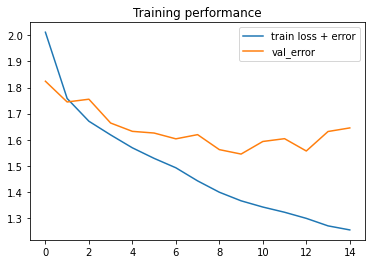

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

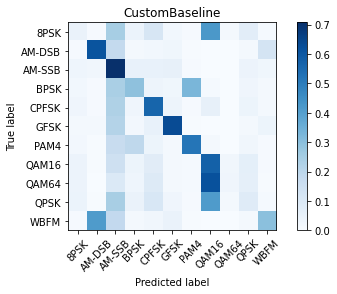

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08283803863298662


Overall Accuracy:  0.09759704251386321


Overall Accuracy:  0.08377518557794274


Overall Accuracy:  0.10260014054813774


Overall Accuracy:  0.11741329479768786


Overall Accuracy:  0.1561045470819907


Overall Accuracy:  0.26334647079899676


Overall Accuracy:  0.3757267441860465


Overall Accuracy:  0.5346112886048988
Overall Accuracy:  0.5923795830337887


Overall Accuracy:  0.5657225853304285


Overall Accuracy:  0.5456184637576632


Overall Accuracy:  0.5525616698292221


Overall Accuracy:  0.5399253731343283
Overall Accuracy:  0.5417867435158501


Overall Accuracy:  0.5490339044841415


Overall Accuracy:  0.5527582376897445


Overall Accuracy:  0.5577284693493795


Overall Accuracy:  0.5556374355195284


Overall Accuracy:  0.5584229390681004


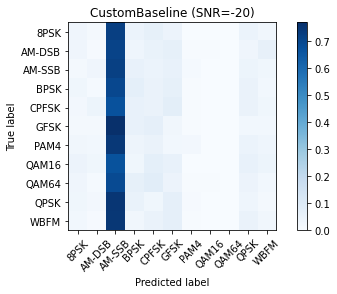

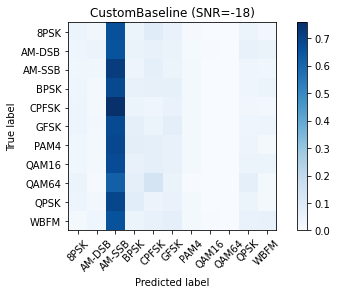

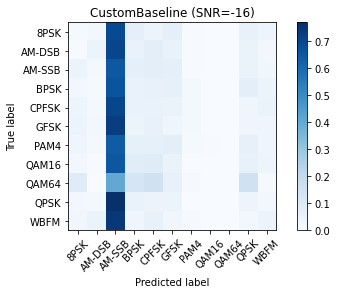

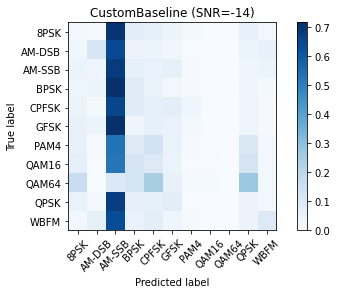

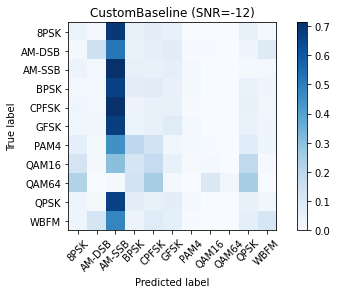

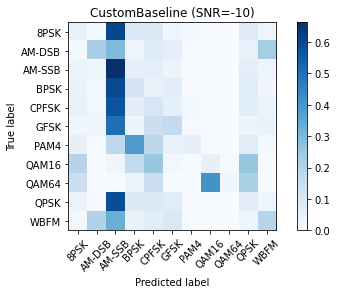

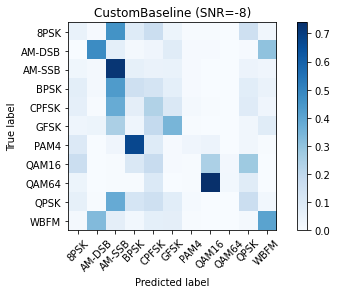

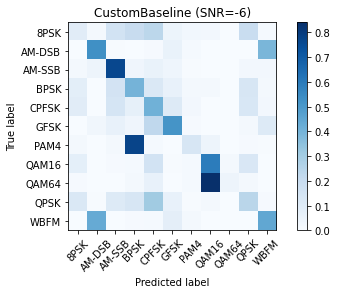

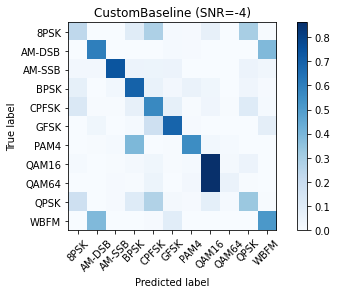

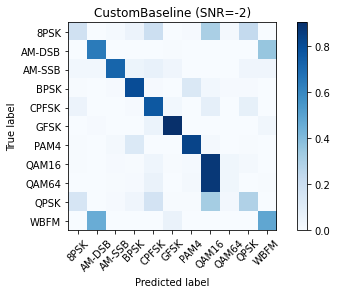

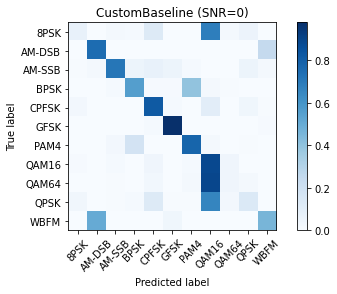

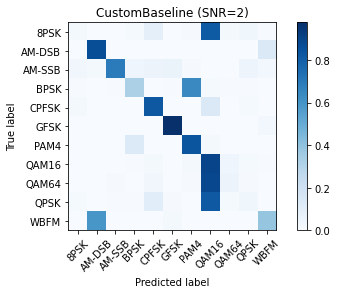

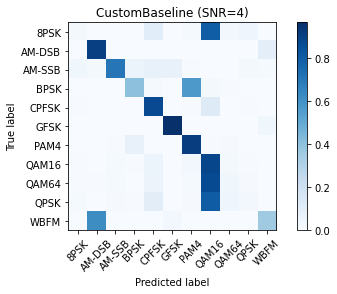

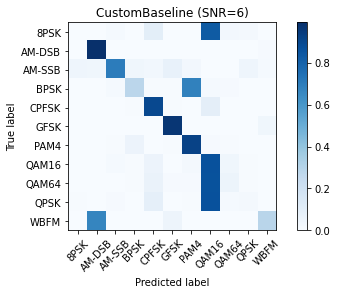

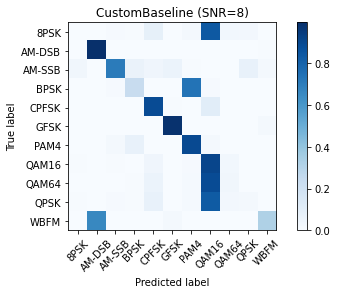

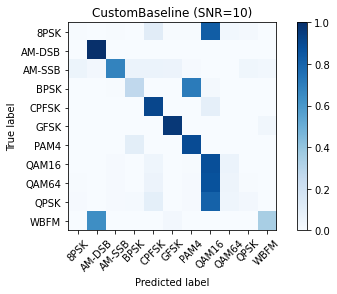

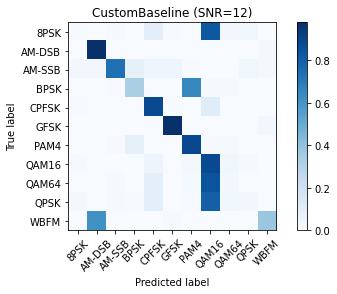

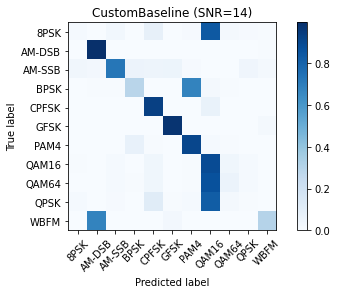

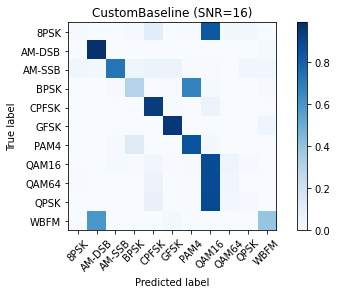

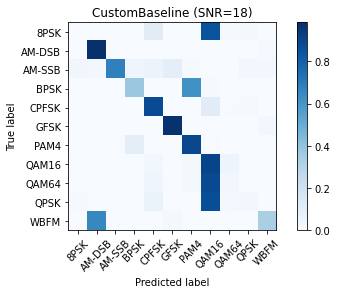

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,8,10,11,15,26,37,53,59,56,54,55,53,54,54,55,55,55,55


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

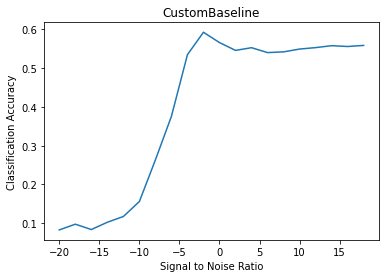

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)